In [1]:
from datetime import datetime as time 
starttime = time.now()
year = starttime.year
month = starttime.month
day = starttime.day
hour_0 = starttime.hour
minute_0 = starttime.minute

if minute_0 < 10:
    minute_0 = '0' + str(minute_0)
    
print('{}|{}|{}  #Year|Month|Day'.format(year, month, day), '\n')
print('Starttime:')
print('{}:{} Uhr'.format(hour_0, minute_0), '\n')

print('End of cluster job:')
hour_1 = hour_0 + 4
if hour_1 >=24:
    day = day + 1
    hour_1 = hour_1 - 24
    print('{}|{}|{}  #Year|Month|Day'.format(year, month, day))
    print('{}:{} Uhr'.format(hour_1, minute_0))
else:
    print('{}:{} Uhr'.format(hour_1, minute_0))

2022|2|10  #Year|Month|Day 

Starttime:
14:10 Uhr 

End of cluster job:
18:10 Uhr


In [2]:
#Creating namespaces for packages
#https://github.com/qubvel/segmentation_models/issues/374
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import get_preprocessing
#from segmentation_models.losses import BinaryCELoss, JaccardLoss, DiceLoss, BinaryFocalLoss
from scipy.ndimage import distance_transform_edt as distance
import random
#from keras.preprocessing.image import ImageDataGenerator
import copy
import csv
import cv2
import pickle
import seaborn as sns
import albumentations as A
from tensorflow.keras.utils import Sequence

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
#Function for validation results
def fun_confusion_matrix (y_prediction, y_mask):
    (pred0, pred1) = np.unique(y_prediction)
    prediction_positive = y_prediction == pred1
    prediction_negative = y_prediction == pred0
    
    (truth0, truth1) = np.unique(y_mask)
    truth_positive = y_mask == truth1
    truth_negative = y_mask == truth0
    
    TP = np.sum(np.logical_and (prediction_positive, truth_positive))
    TN = np.sum(np.logical_and (prediction_negative, truth_negative))
    
    FP = np.sum(truth_negative) - TN
    FN = np.sum(truth_positive) - TP
    return(TP, TN, FP, FN)

def fun_IoU (y_prediction, y_mask):
    TP, TN, FP, FN = fun_confusion_matrix (y_prediction, y_mask)
    IoU_1 = TP / (TP + FP + FN)
    IoU_2 = TN / (TN + FP + FN)
    return(IoU_1, IoU_2, IoU_1 * IoU_2) 

def fun_image_goundtruth (img, mask, name, folder):
    name = name.split('.')[0]
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(img, cmap = 'gray')
    ax[0].set_title(name)
    ax[1].imshow(mask, cmap = 'gray')
    ax[1].set_title('Ground truth')
    plt.tight_layout()
    plt.savefig(folder + name + '_.pdf', dpi = 1000)
    plt.savefig(folder + name + '_.jpeg', dpi = 1000)

In [4]:
folder_array = '../Array_training_validation/'
X_train = np.load(folder_array + 'X_train.npy')
y_train = np.load(folder_array + 'y_train.npy')

X_val = np.load(folder_array + 'X_val.npy')
y_val = np.load(folder_array + 'y_val.npy')

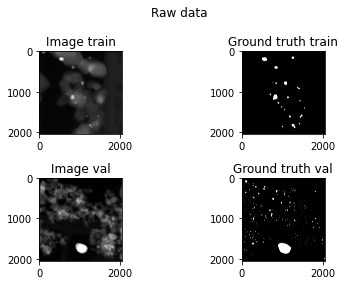


####################################################################
X_train shape:  (46, 2048, 2048) | X_train min:  0.0 X_train max:  1.0
y_train shape:  (46, 2048, 2048) | y_train unique:  [0. 1.]
X_val shape:  (21, 2048, 2048) | X_val min:  0.0 X_val max:  1.0
y_val shape:  (21, 2048, 2048) | y_val unique:  [0. 1.]

####################################################################


In [5]:
#Sanity check image
for i in range (1):
    n_train = random.randint(0, X_train.shape[0]-1)
    n_val = random.randint(0, X_val.shape[0]-1)
    
    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax[0,0].imshow(X_train[n_train,:,:], cmap = 'gray')
    ax[0,0].set_title('Image train')
    ax[0,1].imshow(y_train[n_train,:,:], cmap = 'gray')
    ax[0,1].set_title('Ground truth train')
    ax[1,0].imshow(X_val[n_val,:,:], cmap = 'gray')
    ax[1,0].set_title('Image val')
    ax[1,1].imshow(y_val[n_val,:,:], cmap = 'gray')
    ax[1,1].set_title('Ground truth val')
    fig.suptitle('Raw data')
    plt.tight_layout()
    plt.show()

print('\n####################################################################')
print('X_train shape: ', X_train.shape, '| X_train min: ', X_train.min(), 'X_train max: ', X_train.max())
print('y_train shape: ', y_train.shape, '| y_train unique: ', np.unique(y_train))
print('X_val shape: ', X_val.shape, '| X_val min: ', X_val.min(), 'X_val max: ', X_val.max())
print('y_val shape: ', y_val.shape, '| y_val unique: ', np.unique(y_val))
print('\n####################################################################')

In [6]:
#Apply preprocessing
Backbone = 'seresnet34'
preprocess_resnet = sm.get_preprocessing(Backbone)

X_train = preprocess_resnet(X_train)
X_val = preprocess_resnet(X_val)

In [7]:
model_path = '../Models_Particles/Unet_seresent_IoU_surface_balanced_2/' 
model_name = '67_images_Unet_SE-resnet34_surface_loss'

epochs_each = 100
batch_size = 2
steps_per_epoch =  X_train.shape[0] // batch_size

In [8]:
list_dir = [model_path, model_path + 'Images', model_path + 'Models', model_path + 'Loss']
for dir_name in list_dir:
    try:
        os.makedirs(dir_name)
    except:
        None

In [9]:
print('Max epochs: ', epochs_each)
print('Batch size: ', batch_size)
print('Steps per epoch: ', steps_per_epoch)

Max epochs:  100
Batch size:  2
Steps per epoch:  23


In [10]:
aug_1 = A.VerticalFlip(p=1)
aug_2 = A.HorizontalFlip(p=1)
non_destructive = A.Compose([
    A.OneOf([aug_1, aug_2], p=.5),
    A.RandomRotate90(p=.5),
   ])

aug_3 = A.ShiftScaleRotate(p=1, shift_limit=(-1.0, 1.0), scale_limit=(-0.5, 0.5), rotate_limit=(-45, 45), interpolation=0, border_mode=2, value=(0, 0, 0))
shift_scale_crop = A.OneOf([aug_3], p=0.9)

aug_5 = A.ElasticTransform(p=1, alpha=180, sigma=120 * 0.05, alpha_affine=120 * 0.03)
aug_6 = A.GridDistortion(p=1.0, num_steps=5, distort_limit=(-0.5, 0.5), interpolation=0, border_mode=2)
aug_7 = A.OpticalDistortion(p=1.0, distort_limit=(-0.5, 0.5), shift_limit=(-0.05, 0.05), interpolation=1, border_mode=2)
destructive = A.OneOf([aug_5, aug_6, aug_7], p=0.9)

aug_8 = A.RandomContrast(p=1.0, limit=(-0.2, 0.2))
aug_9 = A.IAASharpen (p=1, alpha=(0.2, 0.5), lightness=(0.5, 1.0))
aug_10 = A.Blur(p=1.0, blur_limit=(3, 20))
pixel = A.OneOf([aug_8, aug_9, aug_10], p=0.1)

augmentation_cascade = A.Compose([non_destructive, shift_scale_crop, destructive, pixel])
    
class albumtations_keras (Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations, augment=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment_boolean = augment
        self.augment = augmentations
        self.number_elements = np.array([n for n in range(x_set.shape[0])])
        self.number_elements_shuffled = np.array(self.number_elements)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def shuffle(self):
        n_shufled = np.random.permutation(self.number_elements)
        return(n_shufled)

    def __getitem__(self, start_step): #get item of the X_train, y_train 
                                #bzw. X_val, y_val
        n_batch = self.number_elements_shuffled[start_step * self.batch_size:(start_step + 1) * self.batch_size]
        batch_x = self.x[n_batch]
        batch_y = self.y[n_batch]
        
        if self.augment_boolean == True:
            img_augmented = []
            mask_augmented = []
            for img, ground_truth in zip(batch_x, batch_y):
                augmented = self.augment(image=img, mask=ground_truth)
                img_augmented.append(augmented['image'])
                mask_augmented.append(augmented['mask'])
            return (np.array(img_augmented), np.array(mask_augmented))
        else:
            return (batch_x, batch_y)
    
    def on_epoch_end(self):
        self.number_elements_shuffled = self.shuffle()
        print('Data set shuffled!')

np.random.seed(seed=42)
train_gen_0 = albumtations_keras(X_train, y_train, batch_size = batch_size, augmentations=augmentation_cascade, augment=False,)
train_gen = albumtations_keras(X_train, y_train, batch_size = batch_size,  augmentations=augmentation_cascade, augment=True,)
cx, cy = train_gen.__getitem__(0)

/home/kit/ttk/fi5314/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/kit/ttk/fi5314/.local/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)


In [11]:
def fun_optimizer (learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(
            learning_rate=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=False,
            name="Adam",
            )
    return (optimizer)

def fun_callback (model_name):
    callbacks_list =  [
    keras.callbacks.EarlyStopping(
    monitor='val_IoU', #'val_loss'
    min_delta=0.001, patience=50, verbose=2,
    mode='max', baseline=None, restore_best_weights=False
    ),
    keras.callbacks.ModelCheckpoint(model_path + 'Models/' + model_name + '.h5', monitor='val_IoU',
    save_weights_only=False, save_best_only=True, mode='max'),
    keras.callbacks.CSVLogger(model_path + 'Models/' + model_name + '.log')]
    return (callbacks_list)

def loss_curve (history, model_name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs / -')
    plt.ylabel('Loss / -')
    plt.legend()
    plt.tight_layout()
    plt.savefig(model_path + 'Loss/' + model_name + '_loss.pdf')
    plt.show()

    acc = history.history['IoU']
    #acc = history.history['accuracy']
    val_acc = history.history['val_IoU']
    #val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training IOU')
    plt.plot(epochs, val_acc, 'r', label='Validation IOU')
    plt.title('Training and validation IOU')
    plt.xlabel('Epochs')
    plt.ylabel('IOU')
    plt.legend()
    plt.tight_layout()
    plt.savefig(model_path + 'Loss/' + model_name + '_IOU.pdf')
    plt.show()
    return (None)

In [12]:
class surface_loss():
    def fun_distance_map (self, ground_truth):
        foreground = ground_truth == ground_truth.max()
        shape_y, shape_x = ground_truth.shape
        
        if foreground.any():
            background = ~foreground
            distance_map = distance(background) * background - (distance(foreground) - 1) * foreground
            distance_map = distance_map / np.sqrt(np.square(shape_y-1) + np.square(shape_x-1))
        else:
            distance_map = np.zeros(shape_y, shape_x)
        return (distance_map)
    
    def fun_distance_map_batch(self, batch_ground_truth):
        batch_ground_truth_numpy = batch_ground_truth.numpy()
        batch_ground_truth_numpy = np.array(batch_ground_truth_numpy, dtype=np.float32)
        distance_map_batch = []
        for ground_truth in batch_ground_truth_numpy:
            distance_map_batch.append(self.fun_distance_map(ground_truth))
        distance_batch = np.array(distance_map_batch)
        return(distance_batch)
    
    def __call__(self, ground_truth, prediction):
        distance_map_batch = tf.py_function(func=self.fun_distance_map_batch,
                                            inp=[ground_truth],
                                            Tout=tf.float32)
        distance = distance_map_batch * prediction 
        return (K.mean(distance))
    
class Loss_rebalanced_tensorflow(keras.layers.Layer):
    def __init__(self, loss_1, loss_2, name=None, beta_1=0.9, beta_2=0.999, beta_weight=0):
        super().__init__(name=name)
        self.t = tf.Variable(100, dtype="float32",  trainable=False)
        
        self.loss_1_fun = loss_1.__call__
        self.loss_2_fun = loss_2.__call__
        
        self.loss_1 = tf.Variable(0, dtype="float32",  trainable=False)
        self.loss_2 = tf.Variable(0, dtype="float32",  trainable=False)
        
        self.delta_loss_1 = tf.Variable(0, dtype="float32",  trainable=False)
        self.delta_loss_2 = tf.Variable(0, dtype="float32",  trainable=False)
        
        self.second_moment_loss_1 = tf.Variable(0, dtype="float32",  trainable=False)
        self.second_moment_loss_2 = tf.Variable(0, dtype="float32",  trainable=False)
        
        self.beta_1 = tf.Variable(beta_1, dtype="float32",  trainable=False)
        self.beta_2 = tf.Variable(beta_2, dtype="float32",  trainable=False)
        self.beta_weight = tf.Variable(beta_weight, dtype="float32",  trainable=False)
        
        self.alpha_epsilon = tf.Variable(1E-2, dtype="float32",  trainable=False)
        self.zero = tf.Variable(0, dtype="float32",  trainable=False)

    def soft_adapt(self, input_1, input_2):
        input_1 = self.beta_weight * input_1
        inpput_2 = self.beta_weight * input_2
        input_max = tf.where(tf.less(input_1, input_2), #condiction
                     input_2, #if true
                     input_1) #if fale
        input_1 = input_1 - input_max
        input_2 = input_2 - input_max
        denominator = tf.math.exp(input_1 + tf.keras.backend.epsilon()) + tf.math.exp(inpput_2 + tf.keras.backend.epsilon()) 
        alpha_1 = tf.math.exp(input_1 + tf.keras.backend.epsilon()) / (denominator + tf.keras.backend.epsilon())
        alpha_2 = 1 - alpha_1 
        return(alpha_1, alpha_2)
    
    def __call__(self, y_ground_truth, y_prediction, sample_weights=None):
        loss_1 = self.loss_1_fun(y_ground_truth, y_prediction)
        loss_2 = self.loss_2_fun(y_ground_truth, y_prediction)        
        
        delta_loss_1 = self.beta_1 * self.delta_loss_1 + (1-self.beta_1) * (loss_1 - self.loss_1)
        delta_loss_1 = delta_loss_1 /  (1-tf.math.pow(self.beta_1, self.t))
        delta_loss_2 = self.beta_1  * self.delta_loss_2 + (1-self.beta_1) * (loss_2 - self.loss_2)
        delta_loss_2 = delta_loss_2 / (1-tf.math.pow(self.beta_1, self.t))
        
        alpha_1, alpha_2 = self.soft_adapt(delta_loss_1, delta_loss_2)

        loss = alpha_1 * loss_1 + alpha_2 * loss_2 
        
        t_new = self.t + 1
        self.t = self.t.assign(t_new)
        self.loss_1 = self.loss_1.assign(loss_1)
        self.loss_2 = self.loss_2.assign(loss_2)
        self.delta_loss_1 = self.delta_loss_1.assign(delta_loss_1)
        self.delta_loss_2 = self.delta_loss_2.assign(delta_loss_2)
        return loss
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "Loss 1": self.loss_1_fun,
            "Loss 2": self.loss_2_fun,
            "Beta 1": self.beta_1,
            "Beta 2": self.beta_2,
            "Beta weight":self.beta_weight,
        })
    
    def old_call(self, y_ground_truth, y_prediction, sample_weights=None):
        loss_1 = self.loss_1_fun(y_ground_truth, y_prediction)
        loss_2 = self.loss_2_fun(y_ground_truth, y_prediction)        
        
        delta_loss_1 = self.beta_1 * self.delta_loss_1 + (1-self.beta_1) * (loss_1 - self.loss_1)
        delta_loss_1 = tf.math.divide_no_nan(delta_loss_1, (1-tf.math.pow(self.beta_1, self.t)))
        delta_loss_2 = self.beta_1  * self.delta_loss_2 + (1-self.beta_1) * (loss_2 - self.loss_2)
        delta_loss_2 = tf.math.divide_no_nan(delta_loss_2, (1-tf.math.pow(self.beta_1, self.t)))
        
        second_moment_loss_1 = self.beta_2 * self.second_moment_loss_1 + (1-self.beta_2) * tf.math.pow(loss_1 - self.loss_1, 2)
        second_moment_loss_2 = self.beta_2 * self.second_moment_loss_2 + (1-self.beta_2) * tf.math.pow(loss_2 - self.loss_2, 2)
        second_moment_loss_1 = tf.math.divide_no_nan(second_moment_loss_1, (1-tf.math.pow(self.beta_2, self.t)))
        second_moment_loss_2 = tf.math.divide_no_nan(second_moment_loss_2, (1-tf.math.pow(self.beta_2, self.t)))
        
        delta_loss_1 = tf.math.divide_no_nan(delta_loss_1, (tf.math.pow(second_moment_loss_1, 0.5) + tf.keras.backend.epsilon()))
        delta_loss_2 = tf.math.divide_no_nan(delta_loss_2, (tf.math.pow(second_moment_loss_2, 0.5) + tf.keras.backend.epsilon()))
        
        alpha_1, alpha_2 = self.soft_adapt(delta_loss_1, delta_loss_2)
        alpha_1 = tf.where(tf.less(alpha_1,  self.alpha_epsilon), self.zero, alpha_1) 
        alpha_2 =tf.where(tf.less(alpha_2,  self.alpha_epsilon), self.zero, alpha_2)  
        loss = alpha_1 * loss_1 + alpha_2 * loss_2 
        tf.print('delta_loss_1')
        tf.print(delta_loss_1)
        tf.print('delta_loss_2')
        tf.print(delta_loss_2)
        tf.print('Alpha_1')
        tf.print(alpha_1)
        t_new = self.t + 1
        self.t = self.t.assign(t_new)
        self.loss_1 = self.loss_1.assign(loss_1)
        self.loss_2 = self.loss_2.assign(loss_2)
        self.delta_loss_1 = self.delta_loss_1.assign(delta_loss_1)
        self.delta_loss_2 = self.delta_loss_2.assign(delta_loss_2)
        self.second_moment_loss_1 = self.second_moment_loss_1.assign(second_moment_loss_1)
        self.second_moment_loss_2 = self.second_moment_loss_1.assign(second_moment_loss_2)
        return loss

class loss_rebalanced(keras.layers.Layer):
    def __init__(self, loss_1, loss_2, beta=0.1):
        self.loss_1 = loss_1
        self.loss_2 = loss_2
        self.beta = beta

    def __call__ (self, y_ground_truth, y_prediction):
        loss_1 = self.loss_1(y_ground_truth, y_prediction)
        loss_2 = self.loss_2(y_ground_truth, y_prediction)

        alpha_1, alpha_2 = self.soft_adapt(loss_1, loss_2, beta=self.beta)
        #loss = alpha_1 * loss_1 + alpha_2 * loss_2
        loss_1_new = tf.math.multiply_no_nan(alpha_1, loss_1)
        loss_2_new = tf.math.multiply_no_nan(alpha_2, loss_2)
        loss = loss_1_new + loss_2_new
        return (loss)

    def soft_adapt(self, input_1, input_2, beta=0.1):
        denominator = tf.math.exp(beta*input_1) + tf.math.exp(beta*input_2)
        alpha_1 = tf.math.exp(beta*input_1) /  denominator
        alpha_2 = tf.math.exp(beta*input_2) /  denominator
        return(alpha_1, alpha_2)

In [13]:
class IoU_loss():
    def __init__(self):
        self.name = 'IoU'
    def __call__(self, y_ground_truth, y_prediction):
        IoU = self.calc_IoU(y_ground_truth, y_prediction)
        return(1-IoU)
    
    def calc_IoU (self, y_ground_truth, y_prediction):
        TP = K.sum(K.flatten(y_ground_truth) * K.flatten(y_prediction))
        FN = K.sum(y_ground_truth) - TP
        FP = K.sum(y_prediction) - TP
        IoU = TP / (TP + FN + FP)
        return(IoU)
    
class IoU_metric():
    def __init__(self, name ='IoU'):
          self.name = name
    
    def IoU (self, y_ground_truth, y_prediction):
        TP = K.sum(K.flatten(y_ground_truth) * K.flatten(y_prediction))
        FN = K.sum(y_ground_truth) - TP
        FP = K.sum(y_prediction) - TP
        IoU = TP / (TP + FN + FP)
        return(IoU)
    
def IoU (y_ground_truth, y_prediction):
    TP = K.sum(K.flatten(y_ground_truth) * K.flatten(y_prediction))
    FN = K.sum(y_ground_truth) - TP
    FP = K.sum(y_prediction) - TP
    IoU = TP / (TP + FN + FP)
    return(IoU)   

In [16]:
surface_IoU_loss = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)

2022-02-08 12:43:53.690464: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 12:44:02.715378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30976 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2022-02-08 12:44:02.754262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30976 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2022-02-08 12:44:02.755740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

In [17]:
model_Unet_SE_Resnet_grayscale_0 = tf.keras.models.load_model('../Models_Particles/SE-Resnet34_grayscale/67_images_Unet_SE-resnet34_encoder_frozen_1_1.h5', compile=False)

In [18]:
model_Unet_SE_Resnet_grayscale_0.compile(optimizer=fun_optimizer(0.001),loss=surface_IoU_loss.__call__, metrics=[IoU_metric().IoU])

In [ ]:
name = 'Encoder_weights_frozen_no_augmentation'
history = model_Unet_SE_Resnet_grayscale_0.fit(train_gen_0, validation_data = (X_val, y_val), steps_per_epoch=steps_per_epoch, epochs = 1, batch_size = batch_size, callbacks =  fun_callback (name))
loss_curve (history, name)

In [ ]:
name = 'Encoder_weights_frozen'
surface_IoU_loss = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_Unet_SE_Resnet_grayscale_1 = tf.keras.models.load_model( model_path + 'Models/Encoder_weights_frozen_no_augmentation.h5', compile=False)
model_Unet_SE_Resnet_grayscale_1.compile(fun_optimizer(0.0001), loss=surface_IoU_loss.__call__, metrics=[IoU_metric().IoU])
history = model_Unet_SE_Resnet_grayscale_1.fit(train_gen, validation_data = (X_val, y_val), steps_per_epoch=steps_per_epoch, epochs = epochs_each, batch_size = batch_size, callbacks =  fun_callback (name))
loss_curve (history, name)

Epoch 1/100
23/23 [==============================] - 105s 5s/step - loss: 0.0908 - IoU: 0.8169 - val_loss: 0.1090 - val_IoU: 0.7782
Data set shuffled!
Epoch 2/100
23/23 [==============================] - 104s 4s/step - loss: 0.1010 - IoU: 0.7950 - val_loss: 0.1089 - val_IoU: 0.7804
Data set shuffled!
Epoch 3/100
23/23 [==============================] - 99s 4s/step - loss: 0.1111 - IoU: 0.7680 - val_loss: 0.1091 - val_IoU: 0.7810
Data set shuffled!
Epoch 4/100
23/23 [==============================] - 96s 4s/step - loss: 0.1006 - IoU: 0.7941 - val_loss: 0.1099 - val_IoU: 0.7777
Data set shuffled!
Epoch 5/100
23/23 [==============================] - 96s 4s/step - loss: 0.1008 - IoU: 0.7940 - val_loss: 0.1103 - val_IoU: 0.7776
Data set shuffled!
Epoch 6/100
23/23 [==============================] - 94s 4s/step - loss: 0.0991 - IoU: 0.7981 - val_loss: 0.1100 - val_IoU: 0.7780
Data set shuffled!
Epoch 7/100
23/23 [==============================] - 97s 4s/step - loss: 0.1114 - IoU: 0.7723 - va

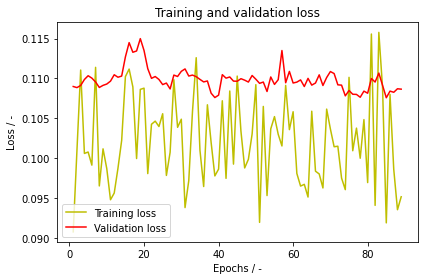

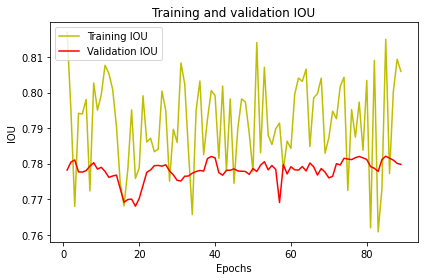

In [24]:
history = model_Unet_SE_Resnet_grayscale_1.fit(train_gen, validation_data = (X_val, y_val), steps_per_epoch=steps_per_epoch, epochs = epochs_each, batch_size = batch_size, callbacks =  fun_callback (name))
loss_curve (history, name)

In [14]:
try:
    model_to_load = 'UNET_SE_RESNET_surface_loss_0.h5'
    model_full_training_0 = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)
    print('Model "{}" loaded, continue training!'.format(model_to_load))
except (OSError):
    model_full_training_0 = tf.keras.models.load_model( model_path + 'Models/' + 'Encoder_weights_frozen.h5', compile=False)
    for layer in model_full_training_0.layers:
        layer.trainable = True

2022-02-08 20:50:29.556514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 20:50:39.038557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30976 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-02-08 20:50:39.155984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30976 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2022-02-08 20:50:39.157490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

Model "UNET_SE_RESNET_surface_loss_0.h5" loaded, continue training!


In [16]:
surface_IoU_loss = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_full_training_0.compile(fun_optimizer(0.00001), loss=surface_IoU_loss.__call__, metrics=[IoU_metric().IoU])

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 0.1076 - IoU: 0.7768

/opt/bwhpc/common/jupyter/tensorflow/2022-01-11/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


23/23 [==============================] - 107s 5s/step - loss: 0.1076 - IoU: 0.7768 - val_loss: 0.1052 - val_IoU: 0.7890
Data set shuffled!
Epoch 2/100
23/23 [==============================] - 98s 4s/step - loss: 0.0979 - IoU: 0.8017 - val_loss: 0.1077 - val_IoU: 0.7828
Data set shuffled!
Epoch 3/100
23/23 [==============================] - 101s 4s/step - loss: 0.0960 - IoU: 0.8050 - val_loss: 0.1105 - val_IoU: 0.7760
Data set shuffled!
Epoch 4/100
23/23 [==============================] - 102s 4s/step - loss: 0.1024 - IoU: 0.7914 - val_loss: 0.1077 - val_IoU: 0.7825
Data set shuffled!
Epoch 5/100
23/23 [==============================] - 108s 5s/step - loss: 0.0838 - IoU: 0.8314 - val_loss: 0.1049 - val_IoU: 0.7869
Data set shuffled!
Epoch 6/100
23/23 [==============================] - 106s 5s/step - loss: 0.0925 - IoU: 0.8116 - val_loss: 0.1049 - val_IoU: 0.7879
Data set shuffled!
Epoch 7/100
23/23 [==============================] - 102s 4s/step - loss: 0.1006 - IoU: 0.7932 - val_loss: 

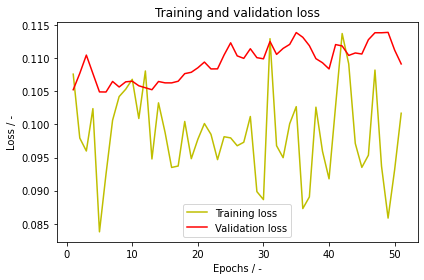

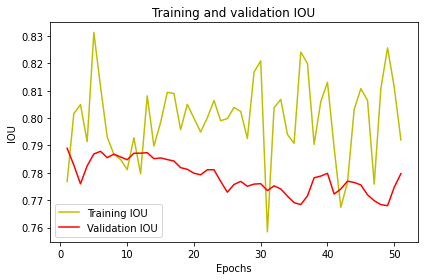

In [18]:
name = 'UNET_SE_RESNET_surface_loss_0'
history = model_full_training_0.fit(train_gen, validation_data = (X_val, y_val), steps_per_epoch=steps_per_epoch, epochs = epochs_each, batch_size = batch_size, callbacks =  fun_callback (name))
loss_curve (history, name)

In [19]:
try:
    model_to_load = 'UNET_SE_RESNET_surface_loss_1.h5'
    model_full_training_1 = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)
    print('Model "{}" loaded, continue training!'.format(model_to_load))
except (OSError):
    model_to_load = 'UNET_SE_RESNET_surface_loss_0.h5'
    model_full_training_1 = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)

surface_IoU_loss = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_full_training_1.compile(fun_optimizer(0.000005), loss=surface_IoU_loss.__call__, metrics=[IoU_metric().IoU])

Model "UNET_SE_RESNET_surface_loss_1.h5" loaded, continue training!


Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 0.0913 - IoU: 0.8074

/opt/bwhpc/common/jupyter/tensorflow/2022-01-11/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


23/23 [==============================] - 113s 5s/step - loss: 0.0913 - IoU: 0.8074 - val_loss: 0.1050 - val_IoU: 0.7878
Data set shuffled!
Epoch 2/100
23/23 [==============================] - 103s 4s/step - loss: 0.0953 - IoU: 0.8063 - val_loss: 0.1051 - val_IoU: 0.7878
Data set shuffled!
Epoch 3/100
23/23 [==============================] - 102s 4s/step - loss: 0.0953 - IoU: 0.8060 - val_loss: 0.1048 - val_IoU: 0.7886
Data set shuffled!
Epoch 4/100
23/23 [==============================] - 102s 4s/step - loss: 0.1002 - IoU: 0.7949 - val_loss: 0.1054 - val_IoU: 0.7876
Data set shuffled!
Epoch 5/100
23/23 [==============================] - 104s 5s/step - loss: 0.1013 - IoU: 0.7930 - val_loss: 0.1051 - val_IoU: 0.7883
Data set shuffled!
Epoch 6/100
23/23 [==============================] - 107s 5s/step - loss: 0.1053 - IoU: 0.7847 - val_loss: 0.1058 - val_IoU: 0.7874
Data set shuffled!
Epoch 7/100
23/23 [==============================] - 102s 4s/step - loss: 0.0970 - IoU: 0.8024 - val_loss:

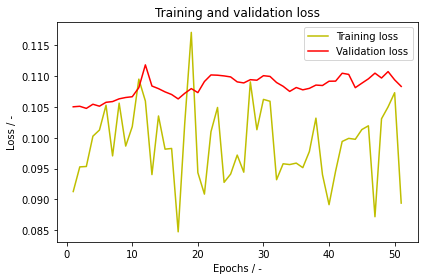

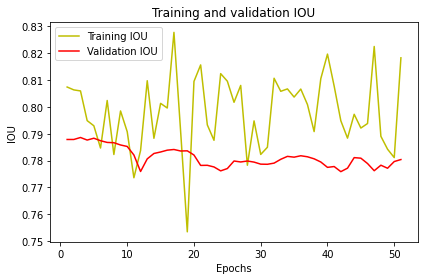

In [20]:
name = 'UNET_SE_RESNET_surface_loss_1'
history = model_full_training_1.fit(train_gen, validation_data = (X_val, y_val), steps_per_epoch=steps_per_epoch, epochs = epochs_each, batch_size = batch_size, callbacks =  fun_callback (name))
loss_curve (history, name)

In [14]:
try:
    model_to_load = 'UNET_SE_RESNET_surface_loss_2.h5'
    model_full_training_1 = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)
    print('Model "{}" loaded, continue training!'.format(model_to_load))
except (OSError):
    model_to_load = 'UNET_SE_RESNET_surface_loss_1.h5'
    model_full_training_1 = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)

surface_IoU_loss = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_full_training_1.compile(fun_optimizer(0.000001), loss=surface_IoU_loss.__call__, metrics=[IoU_metric().IoU])

2022-02-09 09:03:26.190691: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-09 09:03:37.675893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30976 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2022-02-09 09:03:37.708758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30976 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2022-02-09 09:03:37.710287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

Model "UNET_SE_RESNET_surface_loss_2.h5" loaded, continue training!


Epoch 1/100


2022-02-09 09:04:02.078709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


23/23 [==============================] - ETA: 0s - loss: 0.0992 - IoU: 0.7907

/opt/bwhpc/common/jupyter/tensorflow/2022-01-11/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


23/23 [==============================] - 163s 5s/step - loss: 0.0992 - IoU: 0.7907 - val_loss: 0.1047 - val_IoU: 0.7887
Data set shuffled!
Epoch 2/100
23/23 [==============================] - 105s 5s/step - loss: 0.0991 - IoU: 0.7974 - val_loss: 0.1049 - val_IoU: 0.7889
Data set shuffled!
Epoch 3/100
23/23 [==============================] - 100s 4s/step - loss: 0.0968 - IoU: 0.8028 - val_loss: 0.1048 - val_IoU: 0.7889
Data set shuffled!
Epoch 4/100
23/23 [==============================] - 100s 4s/step - loss: 0.1043 - IoU: 0.7867 - val_loss: 0.1052 - val_IoU: 0.7886
Data set shuffled!
Epoch 5/100
23/23 [==============================] - 102s 4s/step - loss: 0.0915 - IoU: 0.8142 - val_loss: 0.1047 - val_IoU: 0.7884
Data set shuffled!
Epoch 6/100
23/23 [==============================] - 99s 4s/step - loss: 0.0982 - IoU: 0.7993 - val_loss: 0.1053 - val_IoU: 0.7882
Data set shuffled!
Epoch 7/100
23/23 [==============================] - 101s 4s/step - loss: 0.0960 - IoU: 0.8037 - val_loss: 

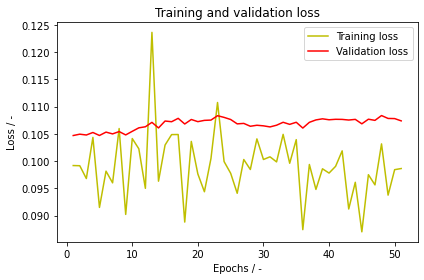

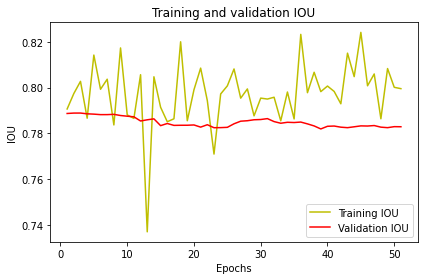

In [15]:
name = 'UNET_SE_RESNET_surface_loss_2'
history = model_full_training_1.fit(train_gen, validation_data = (X_val, y_val), steps_per_epoch=steps_per_epoch, epochs = epochs_each, batch_size = batch_size, callbacks =  fun_callback (name))
loss_curve (history, name)

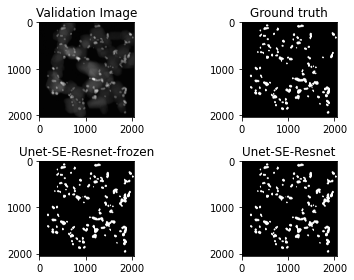

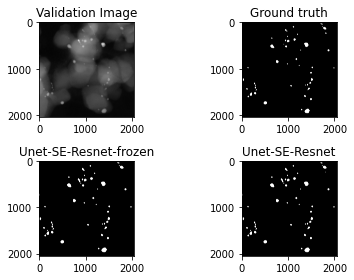

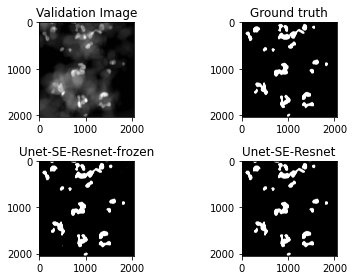

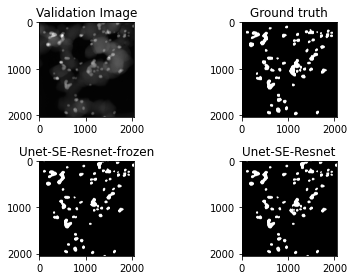

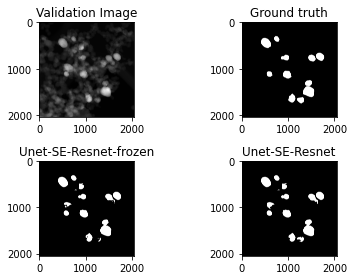

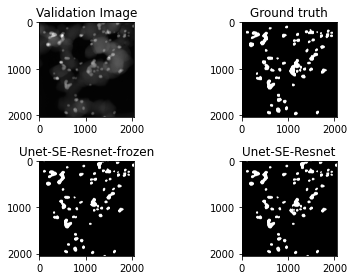

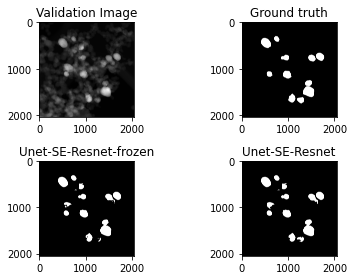

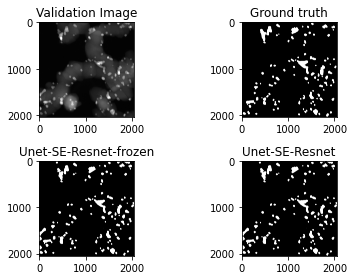

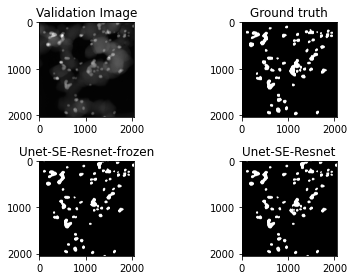

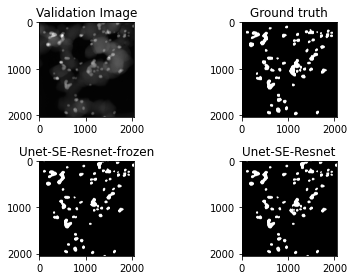

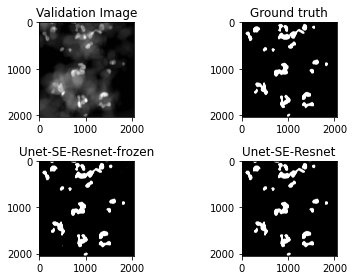

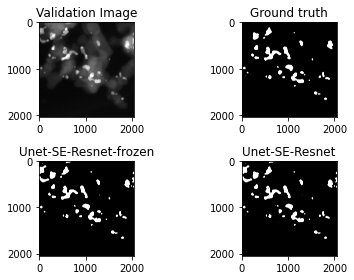

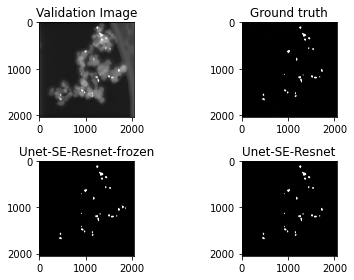

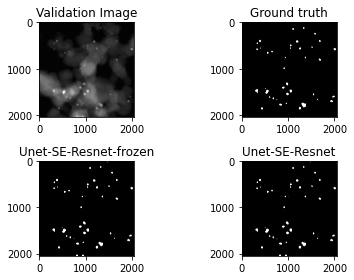

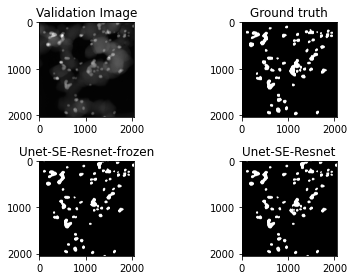

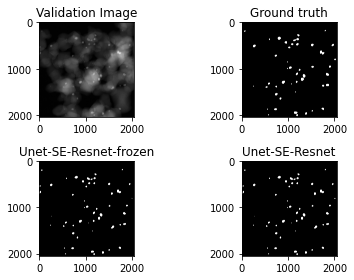

In [16]:
model_1 = tf.keras.models.load_model(model_path + 'Models/Encoder_weights_frozen.h5', compile=False)
model_2 = tf.keras.models.load_model(model_path + 'Models/UNET_SE_RESNET_surface_loss_1.h5', compile=False)
val_img_test_list = []
for i in range (16):
    thresh = 0.5
    test_img_number = random.randint(0, len(X_val)-1)
    val_img_test_list.append(test_img_number)
    test_img = X_val[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    ground_truth=y_val[test_img_number]
    
    prediction_1 = model_1.predict(test_img_input)
    prediction_1 = prediction_1[0,:,:]
    prediction_2 = model_2.predict(test_img_input)
    prediction_2 = prediction_2[0,:,:]

    plt.subplot(221)
    plt.title('Validation Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(222)
    plt.title('Ground truth')
    plt.imshow(ground_truth, cmap='gray')
    plt.subplot(223)
    plt.title('Unet-SE-Resnet-frozen')
    plt.imshow(prediction_1>thresh, cmap='gray')
    plt.subplot(224)
    plt.title('Unet-SE-Resnet')
    plt.imshow(prediction_2>thresh, cmap='gray')
    plt.tight_layout()
    plt.savefig(model_path + 'Images/Thresh0.5_Val_img_' + str(i) + '.pdf', dpi=1000)
    plt.show()
    
pickle.dump(val_img_test_list, open(model_path + 'val_img_test_list', 'wb'))

In [20]:
#IOU
model = tf.keras.models.load_model('../Models_Particles/SE-Resnet34_grayscale/67_images_Unet_SE-resnet34_encoder_frozen_1_1.h5', compile=False)

best_model = 'unknown'
best_model_thresh = 0
best_global_IoU = 0

for model_name_loop in ['Encoder_weights_frozen_no_augmentation', 'Encoder_weights_frozen', 
                        'UNET_SE_RESNET_surface_loss_0', 'UNET_SE_RESNET_surface_loss_1', 'UNET_SE_RESNET_surface_loss_2']:
    model.load_weights (model_path + 'Models/' + model_name_loop + '.h5')
    model_name_1 = model_name_loop

    NB = []
    for n_image in range (X_train.shape[0]):
        img_tensor = X_train[n_image]
        img_tensor = np.expand_dims (img_tensor, axis = 0)
        img_pred = model.predict(img_tensor)
        #import pdb
        #pdb.set_trace()
        NB.append(img_pred[0,:,:,0])
    y_pred_train = np.array(NB)

    NB = []
    for n_image in range (X_val.shape[0]):
        img_tensor = X_val[n_image]
        img_tensor = np.expand_dims (img_tensor, axis = 0)
        img_pred = model.predict(img_tensor)
        NB.append(img_pred[0,:,:,0])
    y_pred_val = np.array(NB)

    del NB    
    del img_pred
    del img_tensor

    IoU_score_list = []
    best_score = 0

    IoU_score_list_2 = []
    best_score_2 = 0

    thresh_max = 5
    print('#############################################################################################################\n')
    print('Name model: ', model_name_loop, '\n')
    
    for count, i in enumerate([i for i in range (1, thresh_max)]):
        thresh = i/10
        y_pred = y_pred_val
        y_pred_thresholded = y_pred > thresh
        IoU1_val, IoU2_val, IoU_product_val = fun_IoU (y_pred_thresholded, y_val)
        print('Threshold: ', thresh, " IoU score_1: ", str(IoU1_val*100)[:5], ' %', " IoU score_2: ", str(IoU2_val*100)[:5], ' %', " IoU product: ", str(IoU_product_val*100)[:5], ' %')
        IoU_score_list.append((thresh, IoU1_val, IoU2_val, IoU_product_val))
        if IoU_product_val > best_score:
            n_best_score = count
            best_score = IoU_product_val
        else:
            None
            
    print('Best threshold: ', IoU_score_list[n_best_score][0], 'Best product IoU val: ', IoU_score_list[n_best_score][-1]) 

    if int(IoU_score_list[n_best_score][0]*10) == 1:
        i_start = 1
    else:
        i_start = int(IoU_score_list[n_best_score][0]*100 - 9)

    for count, i in enumerate([i for i in range (i_start, int(IoU_score_list[n_best_score][0]*100 + 9))]):
        thresh = i/100
        y_pred = y_pred_val
        y_pred_thresholded = y_pred > thresh
        IoU1_val, IoU2_val, IoU_product_val = fun_IoU (y_pred_thresholded, y_val)
        print('Threshold: ', thresh, " IoU score_1: ", str(IoU1_val*100)[:5], ' %', " IoU score_2: ", str(IoU2_val*100)[:5], ' %', " IoU product: ", str(IoU_product_val*100)[:5], ' %')
        IoU_score_list_2.append((thresh, IoU1_val, IoU2_val, IoU_product_val))
        if IoU_product_val > best_score_2:
            n_best_score_2 = count
            best_score_2 = IoU_product_val
        else:
            None

    print('\nBest threshold: ', IoU_score_list_2[n_best_score_2][0], 'Best product IoU val: ', IoU_score_list_2[n_best_score][-1]) 

    thresh = IoU_score_list_2[n_best_score_2][0]

    y_pred = y_pred_train
    y_pred_thresholded = y_pred > thresh
    intersection = np.logical_and(y_train, y_pred_thresholded)
    union = np.logical_or(y_train, y_pred_thresholded)
    iou_score_train = np.sum(intersection) / np.sum(union)
    print("IoU score train is: ", str(iou_score_train*100)[:5], ' %')

    y_pred = y_pred_val
    y_pred_thresholded = y_pred > thresh
    intersection = np.logical_and(y_val, y_pred_thresholded)
    union = np.logical_or(y_val, y_pred_thresholded)
    iou_score_val = np.sum(intersection) / np.sum(union)
    print("IoU score val is: ", str(iou_score_val*100)[:5], ' %')
    
    if IoU_score_list_2[n_best_score][-1] > best_global_IoU:
        best_global_IoU = IoU_score_list_2[n_best_score][-1]
        best_model = model_name_loop
        best_model_thresh = thresh
    else:
        None      

#############################################################################################################

Name model:  Encoder_weights_frozen_no_augmentation 

Threshold:  0.1  IoU score_1:  60.21  %  IoU score_2:  96.91  %  IoU product:  58.35  %
Threshold:  0.2  IoU score_1:  62.23  %  IoU score_2:  97.16  %  IoU product:  60.46  %
Threshold:  0.3  IoU score_1:  63.42  %  IoU score_2:  97.30  %  IoU product:  61.71  %
Threshold:  0.4  IoU score_1:  64.32  %  IoU score_2:  97.41  %  IoU product:  62.66  %
Best threshold:  0.4 Best product IoU val:  0.6266201750070426
Threshold:  0.31  IoU score_1:  63.52  %  IoU score_2:  97.32  %  IoU product:  61.81  %
Threshold:  0.32  IoU score_1:  63.61  %  IoU score_2:  97.33  %  IoU product:  61.92  %
Threshold:  0.33  IoU score_1:  63.71  %  IoU score_2:  97.34  %  IoU product:  62.02  %
Threshold:  0.34  IoU score_1:  63.80  %  IoU score_2:  97.35  %  IoU product:  62.11  %
Threshold:  0.35  IoU score_1:  63.89  %  IoU score_2:  97.36  %

In [21]:
print('Best model name: ', best_model)
model.load_weights (model_path + 'Models/' + best_model + '.h5')
model_name = best_model

NB = []
for n_image in range (X_train.shape[0]):
    img_tensor = X_train[n_image]
    img_tensor = np.expand_dims (img_tensor, axis = 0)
    img_pred = model.predict(img_tensor)
    NB.append(img_pred[0,:,:,0])
y_pred_train = np.array(NB)

NB = []
for n_image in range (X_val.shape[0]):
    img_tensor = X_val[n_image]
    img_tensor = np.expand_dims (img_tensor, axis = 0)
    img_pred = model.predict(img_tensor)
    NB.append(img_pred[0,:,:,0])
y_pred_val = np.array(NB)

del NB    
del img_pred
del img_tensor

thresh = best_model_thresh

y_pred = y_pred_train
y_pred_train_thresholded = y_pred > thresh
intersection = np.logical_and(y_train, y_pred_train_thresholded)
union = np.logical_or(y_train, y_pred_train_thresholded)
iou_score_train = np.sum(intersection) / np.sum(union)
print("IoU score train is: ", str(iou_score_train*100)[:5], ' %')

y_pred = y_pred_val
y_pred_val_thresholded = y_pred > thresh
intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score_val = np.sum(intersection) / np.sum(union)
print("IoU score val is: ", str(iou_score_val*100)[:5], ' %')

Best model name:  UNET_SE_RESNET_surface_loss_2
IoU score train is:  83.90  %
IoU score val is:  79.20  %


In [27]:
csv_path_name = model_path + model_name  + '_overview.csv'
IoU1_train, IoU2_train, IoU_product_train = fun_IoU (y_pred_train_thresholded, y_train)
confusion_matrix_train = fun_confusion_matrix(y_pred_train_thresholded, y_train)
TP_train, TN_train, FP_train, FN_train = confusion_matrix_train

y_pred_val = (y_pred_val > thresh)*1
IoU1_val, IoU2_val, IoU_product_val = fun_IoU (y_pred_val_thresholded, y_val)
confusion_matrix_val = fun_confusion_matrix (y_pred_val_thresholded, y_val)
TP_val, TN_val, FP_val, FN_val = confusion_matrix_val

with open (csv_path_name, 'w', newline = '') as file:
    writer = csv.writer(file, delimiter = ',')
    writer.writerow(['Model', 'Dataset', 'Best threshold', 'IoU_1 / %', 'IoU_2 / %', 'IoU_product / %', 'TP', 'TN', 'FP', 'FN'])
    writer.writerow([model_name,'Train', thresh, IoU1_train*100, IoU2_train*100, IoU_product_train*100, TP_train, TN_train, FP_train, FN_train])
    writer.writerow([model_name,'val', thresh, IoU1_val*100, IoU2_val*100, IoU_product_val*100, TP_val, TN_val, FP_val, FN_val])

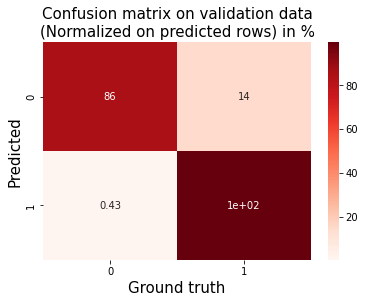

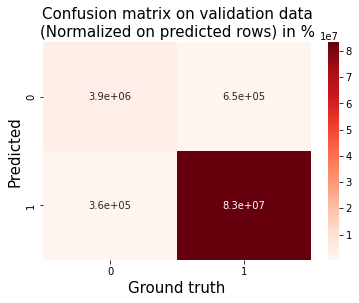

In [28]:
TP = TP_val
FP = FP_val
TN = TN_val
FN = FN_val
confusion_matrix = sns.heatmap(([TP/(TP+FP)*100, FP/(TP+FP)*100], [FN/(TN+FN)*100, TN/(TN+FN)*100]), annot = True, cmap = 'Reds')
plt.xlabel('Ground truth', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.title('Confusion matrix on validation data\n(Normalized on predicted rows) in %', fontsize = 15)
plt.savefig(model_path + model_name + '_normed_Confusionmatrix.pdf')
plt.show()

confusion_matrix = sns.heatmap(([TP, FP], [FN, TN]), annot = True, cmap = 'Reds')
plt.xlabel('Ground truth', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.title('Confusion matrix on validation data\n(Normalized on predicted rows) in %', fontsize = 15)
plt.savefig(model_path + model_name + '_Confusionmatrix.pdf')
plt.show()

In [14]:
model_all = tf.keras.models.load_model(model_path + 'Models/' + 'UNET_SE_RESNET_surface_loss_0.h5', compile=False)
loss_surface = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_all.compile(fun_optimizer(0.00001), loss=loss_surface.__call__, metrics=[IoU_metric().IoU])

2022-02-10 09:19:04.922583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 09:19:07.233341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30974 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2022-02-10 09:19:07.235054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30976 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0
2022-02-10 09:19:07.236596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

In [15]:
IoU_train_mean = 0
for n_image in range (0 , X_train.shape[0]):
    #import pdb;pdb.set_trace()
    x_train = X_train[n_image,:,:]
    x_train = np.expand_dims(x_train, axis=0)
    y_predict = model_all.predict(x_train)
    y_ground_truth = y_train[n_image,:,:]
    IoU_train_mean += float(IoU_metric().IoU(y_predict, y_ground_truth))
IoU_train_mean /=  X_train.shape[0]
print(IoU_train_mean)

2022-02-10 09:19:15.534064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


0.8371134672475897


In [16]:
X_all = np.concatenate((X_train, X_val), axis=0)
y_all = np.concatenate((y_train, y_val), axis=0)
epochs_each = 150
batch_size = 2
steps_per_epoch = X_all.shape[0] // batch_size
 
train_gen_all = albumtations_keras(X_all, y_all, batch_size = batch_size,  augmentations=augmentation_cascade, augment=True,)

In [17]:
X_all = preprocess_resnet(X_all)
print('X_all shape: ', X_all.shape, '| X_all min: ', X_all.min(), 'X_all max: ', X_all.max())
print('y_all shape: ', y_all.shape, '| y_all unique: ', np.unique(y_all))

X_all shape:  (67, 2048, 2048) | X_all min:  0.0 X_all max:  1.0
y_all shape:  (67, 2048, 2048) | y_all unique:  [0. 1.]


In [18]:
class TerminateOnBaseline(keras.callbacks.EarlyStopping):
    """
    20210831: https://stackoverflow.com/questions/53500047/stop-training-in-keras-when-accuracy-is-already-1-0
    Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [19]:
def fun_callback_fine_tuning (model_name,baseline):
    callbacks_list =  [
    TerminateOnBaseline(
    monitor='val_IoU', #'val_loss'
    baseline=baseline
    ),
    keras.callbacks.ModelCheckpoint(model_path + 'Models/' + model_name + '.h5', monitor='val_IoU',
    save_weights_only=False, save_best_only=True, mode='max'),
    keras.callbacks.CSVLogger(model_path + 'Models/' + model_name + '.log')]
    return (callbacks_list)

In [20]:
try:
    model_to_load = 'train_on_X_train_X_val.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)
    print('Model "{}" loaded, continue training!'.format(model_to_load))
except (OSError):
    model_to_load = best_model + '.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)

Model "train_on_X_train_X_val.h5" loaded, continue training!


In [24]:
loss_surface = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_all.compile(fun_optimizer(0.00001), loss=loss_surface.__call__, metrics=[IoU_metric().IoU])

In [ ]:
model_name = 'train_on_X_train_X_val'
history = model_all.fit(train_gen_all, 
                          validation_data=(X_val, y_val), 
                          steps_per_epoch=steps_per_epoch, 
                          epochs=epochs_each, 
                          batch_size=batch_size, 
                          callbacks= fun_callback_fine_tuning (model_name, IoU_train_mean)
                        )

Epoch 1/150
33/33 [==============================] - ETA: 0s - loss: 0.1069 - IoU: 0.7710

/opt/bwhpc/common/jupyter/tensorflow/2022-01-11/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


33/33 [==============================] - 153s 4s/step - loss: 0.1069 - IoU: 0.7710 - val_loss: 0.1024 - val_IoU: 0.7946
Data set shuffled!
Epoch 2/150
33/33 [==============================] - 130s 4s/step - loss: 0.1013 - IoU: 0.7918 - val_loss: 0.1032 - val_IoU: 0.7934
Data set shuffled!
Epoch 3/150
33/33 [==============================] - 128s 4s/step - loss: 0.1067 - IoU: 0.7816 - val_loss: 0.1031 - val_IoU: 0.7930
Data set shuffled!
Epoch 4/150
33/33 [==============================] - 136s 4s/step - loss: 0.1067 - IoU: 0.7777 - val_loss: 0.1028 - val_IoU: 0.7932
Data set shuffled!
Epoch 5/150
33/33 [==============================] - 129s 4s/step - loss: 0.0985 - IoU: 0.7985 - val_loss: 0.1028 - val_IoU: 0.7938
Data set shuffled!
Epoch 6/150
33/33 [==============================] - 131s 4s/step - loss: 0.0991 - IoU: 0.7977 - val_loss: 0.1025 - val_IoU: 0.7940
Data set shuffled!
Epoch 7/150
33/33 [==============================] - 130s 4s/step - loss: 0.1080 - IoU: 0.7772 - val_loss:

In [21]:
try:
    model_to_load = 'train_on_X_train_X_val_2.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)
    print('Model "{}" loaded, continue training!'.format(model_to_load))
except (OSError):
    model_to_load = 'train_on_X_train_X_val' + '.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)

In [22]:
loss_surface = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_all.compile(fun_optimizer(0.00001), loss=loss_surface.__call__, metrics=[IoU_metric().IoU])

In [ ]:
model_name = 'train_on_X_train_X_val_2'
history = model_all.fit(train_gen_all, 
                          validation_data=(X_val, y_val), 
                          steps_per_epoch=steps_per_epoch, 
                          epochs=epochs_each, 
                          batch_size=batch_size, 
                          callbacks= fun_callback_fine_tuning (model_name, IoU_train_mean)
                        )

Epoch 1/150
33/33 [==============================] - ETA: 0s - loss: 0.0968 - IoU: 0.7983

/opt/bwhpc/common/jupyter/tensorflow/2022-01-11/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


33/33 [==============================] - 153s 4s/step - loss: 0.0968 - IoU: 0.7983 - val_loss: 0.0981 - val_IoU: 0.8034
Data set shuffled!
Epoch 2/150
33/33 [==============================] - 133s 4s/step - loss: 0.1004 - IoU: 0.7931 - val_loss: 0.0982 - val_IoU: 0.8035
Data set shuffled!
Epoch 3/150
33/33 [==============================] - 129s 4s/step - loss: 0.1064 - IoU: 0.7828 - val_loss: 0.0980 - val_IoU: 0.8035
Data set shuffled!
Epoch 4/150
33/33 [==============================] - 134s 4s/step - loss: 0.0943 - IoU: 0.8072 - val_loss: 0.0974 - val_IoU: 0.8047
Data set shuffled!
Epoch 5/150
33/33 [==============================] - 130s 4s/step - loss: 0.0995 - IoU: 0.7973 - val_loss: 0.0975 - val_IoU: 0.8054
Data set shuffled!
Epoch 6/150
33/33 [==============================] - 130s 4s/step - loss: 0.1049 - IoU: 0.7878 - val_loss: 0.0997 - val_IoU: 0.8016
Data set shuffled!
Epoch 7/150
33/33 [==============================] - 130s 4s/step - loss: 0.0985 - IoU: 0.7994 - val_loss:

In [24]:
try:
    model_to_load = 'train_on_X_train_X_val_3.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)
    print('Model "{}" loaded, continue training!'.format(model_to_load))
except (OSError):
    model_to_load ='train_on_X_train_X_val_2.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)

In [25]:
loss_surface = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_all.compile(fun_optimizer(0.00001), loss=loss_surface.__call__, metrics=[IoU_metric().IoU])

In [ ]:
model_name = 'train_on_X_train_X_val_3'
history = model_all.fit(train_gen_all, 
                          validation_data=(X_val, y_val), 
                          steps_per_epoch=steps_per_epoch, 
                          epochs=epochs_each, 
                          batch_size=batch_size, 
                          callbacks= fun_callback_fine_tuning (model_name, IoU_train_mean)
                        )

Epoch 1/150
33/33 [==============================] - ETA: 0s - loss: 0.0883 - IoU: 0.8168

/opt/bwhpc/common/jupyter/tensorflow/2022-01-11/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


33/33 [==============================] - 158s 4s/step - loss: 0.0883 - IoU: 0.8168 - val_loss: 0.0921 - val_IoU: 0.8166
Data set shuffled!
Epoch 2/150
33/33 [==============================] - 138s 4s/step - loss: 0.1006 - IoU: 0.7931 - val_loss: 0.0930 - val_IoU: 0.8156
Data set shuffled!
Epoch 3/150
33/33 [==============================] - 137s 4s/step - loss: 0.0942 - IoU: 0.8061 - val_loss: 0.0936 - val_IoU: 0.8129
Data set shuffled!
Epoch 4/150
33/33 [==============================] - 137s 4s/step - loss: 0.0952 - IoU: 0.8069 - val_loss: 0.0950 - val_IoU: 0.8107
Data set shuffled!
Epoch 5/150
33/33 [==============================] - 131s 4s/step - loss: 0.0947 - IoU: 0.8079 - val_loss: 0.0934 - val_IoU: 0.8127
Data set shuffled!
Epoch 6/150
33/33 [==============================] - 130s 4s/step - loss: 0.0859 - IoU: 0.8243 - val_loss: 0.0922 - val_IoU: 0.8161
Data set shuffled!
Epoch 7/150
33/33 [==============================] - 130s 4s/step - loss: 0.0991 - IoU: 0.7974 - val_loss:

In [ ]:
try:
    model_to_load = 'train_on_X_train_X_val_4.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)
    print('Model "{}" loaded, continue training!'.format(model_to_load))
except (OSError):
    model_to_load ='train_on_X_train_X_val_3.h5'
    model_all = tf.keras.models.load_model( model_path + 'Models/' + model_to_load, compile=False)

In [ ]:
loss_surface = Loss_rebalanced_tensorflow(IoU_loss(), surface_loss(), beta_weight=-10)
model_all.compile(fun_optimizer(0.00001), loss=loss_surface.__call__, metrics=[IoU_metric().IoU])

In [ ]:
model_name = 'train_on_X_train_X_val_4'
IoU_train_mean = 0.8371134672475897
history = model_all.fit(train_gen_all, 
                          validation_data=(X_val, y_val), 
                          steps_per_epoch=steps_per_epoch, 
                          epochs=epochs_each, 
                          batch_size=batch_size, 
                          callbacks= fun_callback_fine_tuning (model_name, IoU_train_mean)
                        )

In [7]:
import shutil
import os

In [8]:
os.getcwd()

'/pfs/data5/home/kit/ttk/fi5314/Training images/20210416_Data set/Deep learning/Models_Particles/Unet_seresent_IoU_surface_balanced_2'

In [9]:
shutil.make_archive(model_path, 'zip', model_path)

'/pfs/data5/home/kit/ttk/fi5314/Training images/20210416_Data set/Deep learning/Models_Particles/Unet_seresent_IoU_surface_balanced_2.zip'